In [1]:
import pyBigWig
import pandas as pd
import numpy as np
import deepdish as dd
import os
import pyfaidx
import random
import pickle as pkl
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import tensorflow as tf
import argparse
import json
import one_hot as dinuc_shuffle_main
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.models import load_model
import tensorflow as tf
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 

In [2]:
regions = "/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/IMR90/negatives_data/negatives_with_summit.bed"
genome = "/mnt/lab_data2/anusri/chrombpnet/reference/hg38.genome.fa"




In [3]:
def softmax(x, temp=1):
    norm_x = x - np.mean(x,axis=1, keepdims=True)
    return np.exp(temp*norm_x)/np.sum(np.exp(temp*norm_x), axis=1, keepdims=True)


def get_footprint_for_motif(seqs, motif, model, inputlen, batch_size):
    '''
    Returns footprints for a given motif. Motif is inserted in both the actual sequence and reverse complemented version.
    seqs input is already assumed to be one-hot encoded. motif is in sequence format.
    '''
    midpoint=inputlen//2

    w_mot_seqs = seqs.copy()
    w_mot_seqs[:, midpoint-len(motif)//2:midpoint-len(motif)//2+len(motif)] =dinuc_shuffle_main.dna_to_one_hot([motif])

    # midpoint of motif is the midpoint of sequence
    pred_output=model.predict(w_mot_seqs, batch_size=batch_size, verbose=True)
    footprint_for_motif_fwd = softmax(pred_output[0])*(np.exp(pred_output[1])-1)

    # reverse complement the sequence
    w_mot_seqs_revc = w_mot_seqs[:, ::-1, ::-1]
    pred_output_rev=model.predict(w_mot_seqs_revc, batch_size=batch_size, verbose=True)
    footprint_for_motif_rev = softmax(pred_output_rev[0])*(np.exp(pred_output_rev[1])-1)

    # add fwd sequence predictions and reverse sesquence predictions (not we flip the rev predictions)
    counts_for_motif = np.exp(pred_output_rev[1]) - 1 + np.exp(pred_output[1]) - 1
    footprint_for_motif_tot = footprint_for_motif_fwd+footprint_for_motif_rev[:,::-1]
    footprint_for_motif =  footprint_for_motif_tot / footprint_for_motif_tot.sum(axis=1)[:, np.newaxis]
    k_l=1000
    if counts_for_motif.shape[0] > k_l:
        print(counts_for_motif.shape)
        smallest_100 = np.argpartition(counts_for_motif[:,0], k_l)[:k_l]
        return footprint_for_motif_tot[smallest_100].mean(0), counts_for_motif[smallest_100].mean(0), smallest_100
    else:
        return footprint_for_motif_tot.mean(0), counts_for_motif.mean(0), None

def get_footprint_for_two_motifs(seqs, motifs, model, inputlen, batch_size, spacing):
    '''
    Returns footprints for a given motif. Motif is inserted in both the actual sequence and reverse complemented version.
    seqs input is already assumed to be one-hot encoded. motif is in sequence format.
    '''
    midpoint=inputlen//2

    spacing_per_motif = spacing // 2
    
    w_mot_seqs = seqs.copy()
    
    motif = motifs[0]
    start = midpoint-(len(motif)//2)
    w_mot_seqs[:, start:start+len(motif)] = dinuc_shuffle_main.dna_to_one_hot([motif])
    print(motif,start,start+len(motif))
    if spacing > 0:
        spacing_per_motif = spacing 
        motif = motifs[1]
        start = start+len(motifs[0])+spacing_per_motif 
        w_mot_seqs[:, start:start+len(motif)] = dinuc_shuffle_main.dna_to_one_hot([motif])
    else:
        spacing_per_motif = spacing 
        motif = motifs[1]
        start = start + spacing_per_motif - len(motif)
        w_mot_seqs[:, start:start+len(motif)] = dinuc_shuffle_main.dna_to_one_hot([motif])
    

    # midpoint of motif is the midpoint of sequence
    pred_output=model.predict(w_mot_seqs, batch_size=batch_size, verbose=True)
    footprint_for_motif_fwd = softmax(pred_output[0])*(np.exp(pred_output[1])-1)

    # reverse complement the sequence
    w_mot_seqs_revc = w_mot_seqs[:, ::-1, ::-1]
    pred_output_rev=model.predict(w_mot_seqs_revc, batch_size=batch_size, verbose=True)
    footprint_for_motif_rev = softmax(pred_output_rev[0])*(np.exp(pred_output_rev[1])-1)

    # add fwd sequence predictions and reverse sesquence predictions (not we flip the rev predictions)
    counts_for_motif = np.exp(pred_output_rev[1]) - 1 + np.exp(pred_output[1]) - 1
    footprint_for_motif_tot = footprint_for_motif_fwd+footprint_for_motif_rev[:,::-1]
    footprint_for_motif =  footprint_for_motif_tot / footprint_for_motif_tot.sum(axis=1)[:, np.newaxis]

    return footprint_for_motif_tot.mean(0), counts_for_motif.mean(0)

In [4]:
def get_seq(peaks_df, genome, width, shuffle=False):
    """
    fetches sequence from a given genome.
    """
    vals = []

    for i, r in peaks_df.iterrows():
        sequence = str(genome[r['chr']][(r['start']+r['summit'] - width//2):(r['start'] + r['summit'] + width//2)])
        if len(sequence) == width:
                vals.append(sequence)

    return dinuc_shuffle_main.dna_to_one_hot(vals)

In [12]:
NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]
inputlen = 2114
regions_df = pd.read_csv(regions, sep='\t', names=NARROWPEAK_SCHEMA)
regions_subsample = regions_df.sample(10000)
genome_fasta = pyfaidx.Fasta(genome)
regions_seqs = get_seq(regions_subsample, genome_fasta, inputlen)

In [13]:
data = pd.read_csv("/mnt/lab_data2/anusri/chrombpnet/logs/checkpoint/JAN_02_2023/model_dir_atac.csv",header=None)
cell_type="IMR90"
ndata = data[data[1]==cell_type].reset_index()

In [14]:
motif =  ""
batch_size=128
k_l=1000
motifs_footprint = {}

for i,r in ndata.iterrows():
    print(i)
    if i==0:
        mdl_path1 = os.path.join(r[2],"chrombpnet_model/new_model_formats/chrombpnet_wo_bias")
        if not os.path.exists(mdl_path1):
            break
        
        model=load_model(mdl_path1, compile=False)
        print(regions_seqs.shape)
        full_footprint_1 = get_footprint_for_motif(regions_seqs, motif, model, inputlen, batch_size)
        regions_seqs = regions_seqs[full_footprint_1[2],:,:]
        print(regions_seqs.shape)
        motifs_footprint["control"] = full_footprint_1[0]
    else:
        mdl_path1 = os.path.join(r[2],"chrombpnet_model/new_model_formats/chrombpnet_wo_bias")
        model=load_model(mdl_path1, compile=False)
        full_footprint_1 = get_footprint_for_motif(regions_seqs, motif, model, inputlen, batch_size)
        motifs_footprint["control"] += full_footprint_1[0]
        
motifs_footprint["control"] = motifs_footprint["control"]/5    

0
(10000, 2114, 4)
79/79 [==============================] - 38s 485ms/step
(10000, 1)
(1000, 2114, 4)
1
8/8 [==============================] - 3s 485ms/step
2
8/8 [==============================] - 4s 483ms/step
3
8/8 [==============================] - 3s 486ms/step
4
8/8 [==============================] - 3s 486ms/step


In [19]:
motif="AGGAATGT"
#motif="CAGGTG"
batch_size=128

for i,r in ndata.iterrows():
    print(i)
    mdl_path1 = os.path.join(r[2],"chrombpnet_model/new_model_formats/chrombpnet_wo_bias")
    model=load_model(mdl_path1, compile=False)
    full_footprint_1 = get_footprint_for_motif(regions_seqs, motif, model, inputlen, batch_size)
    if i==0:
        motifs_footprint["TEAD"] = full_footprint_1[0]
    else:
        motifs_footprint["TEAD"] += full_footprint_1[0]

motifs_footprint["TEAD"] =  motifs_footprint["TEAD"] / 5

0
8/8 [==============================] - 3s 477ms/step
1
8/8 [==============================] - 3s 476ms/step
2
8/8 [==============================] - 3s 480ms/step
3
8/8 [==============================] - 3s 480ms/step
4
8/8 [==============================] - 3s 481ms/step


In [20]:
motif = "TTGACTCA"
#motif="TGACTCA"
#motif="ATGACTCA"
batch_size=128

for i,r in ndata.iterrows():
    print(i)
    mdl_path1 = os.path.join(r[2],"chrombpnet_model/new_model_formats/chrombpnet_wo_bias")
    model=load_model(mdl_path1, compile=False)
    full_footprint_1 = get_footprint_for_motif(regions_seqs, motif, model, inputlen, batch_size)
    if i==0:
        motifs_footprint["AP1"] = full_footprint_1[0]
    else:
        motifs_footprint["AP1"] += full_footprint_1[0]

motifs_footprint["AP1"] =  motifs_footprint["AP1"] / 5

0
8/8 [==============================] - 3s 483ms/step
1
8/8 [==============================] - 3s 482ms/step
2
8/8 [==============================] - 3s 483ms/step
3
8/8 [==============================] - 3s 484ms/step
4
8/8 [==============================] - 3s 484ms/step


In [21]:

motifs = ["AGGAATGT","TTGACTCA"]
#motifs=["CAGGTG", "TGACTCA"]
#motifs=["CAGGTG", "ATGACTCA"]
batch_size=128
#puu_runx_footprint = get_footprint_for_motif(regions_seqs, motif, model, inputlen, batch_size)
for i,r in ndata.iterrows():
    print(i)
    mdl_path1 = os.path.join(r[2],"chrombpnet_model/new_model_formats/chrombpnet_wo_bias")
    model=load_model(mdl_path1, compile=False)
    full_footprint_1 = get_footprint_for_two_motifs(regions_seqs, motifs, model, inputlen, batch_size, spacing=-6)
    if i==0:
        motifs_footprint["AP1-TEAD"] = full_footprint_1[0]
    else:
        motifs_footprint["AP1-TEAD"] += full_footprint_1[0]

motifs_footprint["AP1-TEAD"] =  motifs_footprint["AP1-TEAD"] / 5

#puu_runx_footprint = get_footprint_for_two_motifs(regions_seqs, motifs, model, inputlen, batch_size, spacing=-4)

0
AGGAATGT 1053 1061
8/8 [==============================] - 3s 478ms/step
1
AGGAATGT 1053 1061
8/8 [==============================] - 3s 479ms/step
2
AGGAATGT 1053 1061
8/8 [==============================] - 4s 481ms/step
3
AGGAATGT 1053 1061
8/8 [==============================] - 3s 482ms/step
4
AGGAATGT 1053 1061
8/8 [==============================] - 4s 483ms/step


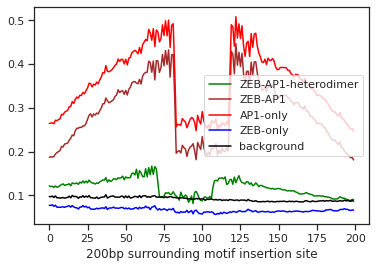

In [12]:
# import seaborn as sns
# sns.set()
# sns.set_style("ticks", {'axes.grid' : False})
# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42 

# #plt.plot(puu_runx_footprint[0][400:600], label="AP1-TEAD-heterodimer", c = "green")
# #plt.plot(irf1_footprint[0][400:600]+runx_footprint[0][400:600], label="AP1+TEAD", c = "brown")
# #plt.plot(irf1_footprint[0][400:600], label="AP1-only", c = "red", alpha=1)
# #plt.plot(runx_footprint[0][400:600], label="TEAD-only", c = "blue", alpha=1)
# #plt.plot(full_footprint_1[0][400:600], label="background", c = "black", alpha=1)

# plt.plot(puu_runx_footprint[0][400:600], label="ZEB-AP1-heterodimer", c = "green")
# plt.plot(irf1_footprint[0][400:600]-runx_footprint[0][400:600], label="ZEB-AP1", c = "brown")
# plt.plot(irf1_footprint[0][400:600], label="AP1-only", c = "red", alpha=1)
# plt.plot(runx_footprint[0][400:600], label="ZEB-only", c = "blue", alpha=1)
# plt.plot(full_footprint_1[0][400:600], label="background", c = "black", alpha=1)
# plt.xlabel("200bp surrounding motif insertion site")
# #plt.ylabel("Total counts")

# #plt.ylim((0,2.5))
# plt.legend(loc="right")

# #plt.savefig("subfigs/ap1_tead_coord_effect.pdf", transparent=True, dpi=300)
# plt.savefig("subfigs/zeb_ap1_coord_effect.pdf", transparent=True, dpi=300)


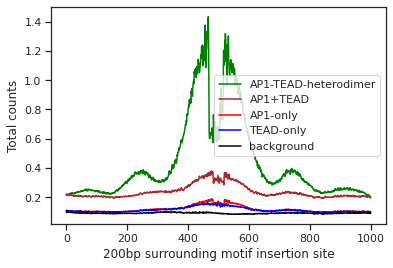

In [21]:
import seaborn as sns
sns.set()
sns.set_style("ticks", {'axes.grid' : False})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 

plt.plot(motifs_footprint["AP1"]], label="AP1-TEAD-heterodimer", c = "green")
plt.plot(irf1_footprint[0]+irf1_footprint[0], label="AP1+TEAD", c = "brown")
plt.plot(irf1_footprint[0], label="AP1-only", c = "red", alpha=1)
plt.plot(runx_footprint[0], label="TEAD-only", c = "blue", alpha=1)
plt.plot(full_footprint_1[0], label="background", c = "black", alpha=1)
plt.xlabel("200bp surrounding motif insertion site")
plt.ylabel("Total counts")

#plt.ylim((0,2.5))
plt.legend(loc="right")

#plt.savefig("subfigs/ap1_tead_coord_effect.pdf", transparent=True, dpi=300)


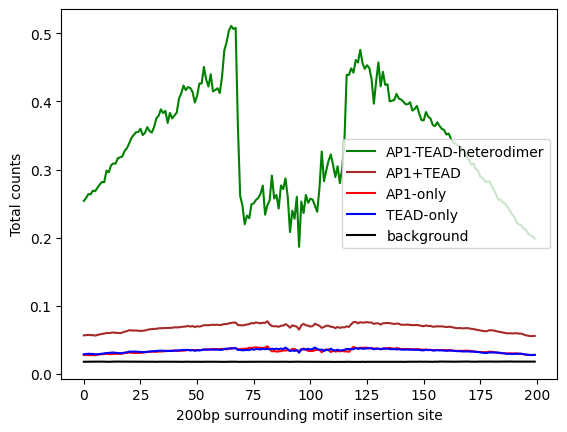

In [24]:

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 

plt.plot(motifs_footprint["AP1-TEAD"][400:600], label="AP1-TEAD-heterodimer", c = "green")
plt.plot(motifs_footprint["AP1"][400:600]+motifs_footprint["TEAD"][400:600], label="AP1+TEAD", c = "brown")
plt.plot(motifs_footprint["AP1"][400:600], label="AP1-only", c = "red", alpha=1)
plt.plot(motifs_footprint["TEAD"][400:600], label="TEAD-only", c = "blue", alpha=1)
plt.plot(motifs_footprint["control"][400:600], label="background", c = "black", alpha=1)
plt.xlabel("200bp surrounding motif insertion site")
plt.ylabel("Total counts")

#plt.ylim((0,2.5))
plt.legend(loc="right")